**Importing Necessary Libraries**

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
# Loading the SVHN dataset
trainset = torchvision.datasets.SVHN(root='/tmp/data', split='train', download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.SVHN(root='/tmp/data', split='test', download=True, transform=transforms.ToTensor())

# Selecting a subset of the data (1000 images per class)
trainsubset = torch.utils.data.Subset(trainset, indices=[i for i in range(1000*10)])
testsubset = torch.utils.data.Subset(testset, indices=[i for i in range(1000*10)])

Using downloaded and verified file: /tmp/data/train_32x32.mat
Using downloaded and verified file: /tmp/data/test_32x32.mat


**Step 2: Data Preprocessing**

In [27]:
# Transforming the data

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resized images to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalized pixel values
])

# Applying data transforms to the subsets
trainsubset.transform = data_transforms
testsubset.transform = data_transforms

# Splitying the dataset into training, validation, and test sets
trainsize = int(0.8 * len(trainsubset))
valsize = len(trainsubset) - trainsize
traindataset, valdataset = torch.utils.data.random_split(trainsubset, [trainsize, valsize])

testdataset = testsubset

**Step 3: Model Selection and Architecture**

In [28]:
class SVNHModel(nn.Module):
    def __init__(self):
        super(SVNHModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(128*4*4, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.output = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.output(x)
        return F.softmax(x, dim=1)

**Step 4: Model Training**

In [13]:
# Defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading the training dataset
trainloader = DataLoader(trainsubset, batch_size=32, shuffle=True)

# Initializing the model, loss function, and optimizer
model = SVNHModel()
model.to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store the loss and accuracy values
lossvalues = []
accuracyvalues = []

# Training the model
for epoch in range(50):  # Train for 50 epochs
    model.train()
    totalloss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        totalloss += loss.item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()

    accuracy = correct / len(trainloader.dataset)
    lossvalues.append(totalloss / len(trainloader))
    accuracyvalues.append(accuracy) 
    print(f'Epoch {epoch+1}, Loss: {totalloss / len(trainloader):4f}, Accuracy: {accuracy:.2f}')

model.eval()

Epoch 1, Loss: 2.081765, Accuracy: 0.38
Epoch 2, Loss: 1.920590, Accuracy: 0.54
Epoch 3, Loss: 1.889700, Accuracy: 0.57
Epoch 4, Loss: 1.881069, Accuracy: 0.58
Epoch 5, Loss: 1.827446, Accuracy: 0.64
Epoch 6, Loss: 1.757502, Accuracy: 0.71
Epoch 7, Loss: 1.729617, Accuracy: 0.73
Epoch 8, Loss: 1.711035, Accuracy: 0.75
Epoch 9, Loss: 1.694951, Accuracy: 0.77
Epoch 10, Loss: 1.656263, Accuracy: 0.81
Epoch 11, Loss: 1.630064, Accuracy: 0.84
Epoch 12, Loss: 1.612117, Accuracy: 0.85
Epoch 13, Loss: 1.595737, Accuracy: 0.87
Epoch 14, Loss: 1.584629, Accuracy: 0.88
Epoch 15, Loss: 1.576061, Accuracy: 0.89
Epoch 16, Loss: 1.567183, Accuracy: 0.90
Epoch 17, Loss: 1.567199, Accuracy: 0.90
Epoch 18, Loss: 1.558022, Accuracy: 0.91
Epoch 19, Loss: 1.555650, Accuracy: 0.91
Epoch 20, Loss: 1.547747, Accuracy: 0.92
Epoch 21, Loss: 1.544005, Accuracy: 0.92
Epoch 22, Loss: 1.541969, Accuracy: 0.92
Epoch 23, Loss: 1.537770, Accuracy: 0.93
Epoch 24, Loss: 1.536982, Accuracy: 0.93
Epoch 25, Loss: 1.535193,

SVNHModel(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Sequential(
    (0): Linear(in_features=2048, out_features

**Step 5: Hyperparameter Tuning**

In [15]:
# Defining the hyperparameter tuning space
hyperparameter = {
    'learningrate': [0.001, 0.0001],
    'batchsize': [32, 64],
    'epochs': [20]
}

# Initializing a dictionary to store the results
results = {}

# Iterating over the hyperparameter tuning space
for learningrate in hyperparameter['learningrate']:
    for batchsize in hyperparameter['batchsize']:
        for epochs in hyperparameter['epochs']:

            # Initializing the model, loss function, and optimizer
            model = SVNHModel()
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learningrate)

            # Training the model
            for epoch in range(epochs):
                model.train()
                total_loss = 0
                correct = 0
                for batch_idx, (data, target) in enumerate(DataLoader(trainsubset, batch_size=batchsize, shuffle=True)):
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    correct += (predicted == target).sum().item()

                accuracy = correct / len(trainsubset)
                print(f'Epoch {epoch+1}, Loss: {total_loss / len(trainsubset):4f}, Accuracy: {accuracy:.2f}')


Epoch 1, Loss: 0.069365, Accuracy: 0.24
Epoch 2, Loss: 0.062550, Accuracy: 0.46
Epoch 3, Loss: 0.060258, Accuracy: 0.54
Epoch 4, Loss: 0.059254, Accuracy: 0.57
Epoch 5, Loss: 0.058931, Accuracy: 0.58
Epoch 6, Loss: 0.058767, Accuracy: 0.58
Epoch 7, Loss: 0.058522, Accuracy: 0.59
Epoch 8, Loss: 0.058120, Accuracy: 0.60
Epoch 9, Loss: 0.057174, Accuracy: 0.64
Epoch 10, Loss: 0.056863, Accuracy: 0.65
Epoch 11, Loss: 0.056787, Accuracy: 0.65
Epoch 12, Loss: 0.056522, Accuracy: 0.66
Epoch 13, Loss: 0.055359, Accuracy: 0.69
Epoch 14, Loss: 0.054867, Accuracy: 0.71
Epoch 15, Loss: 0.054025, Accuracy: 0.74
Epoch 16, Loss: 0.053437, Accuracy: 0.76
Epoch 17, Loss: 0.053178, Accuracy: 0.76
Epoch 18, Loss: 0.052430, Accuracy: 0.79
Epoch 19, Loss: 0.051713, Accuracy: 0.81
Epoch 20, Loss: 0.051467, Accuracy: 0.82
Epoch 1, Loss: 0.033447, Accuracy: 0.33
Epoch 2, Loss: 0.030320, Accuracy: 0.53
Epoch 3, Loss: 0.029730, Accuracy: 0.57
Epoch 4, Loss: 0.029529, Accuracy: 0.58
Epoch 5, Loss: 0.029367, Accu

In [17]:

# Calculating the average accuracy over all epochs
totalcorrect = 0
averageaccuracy = totalcorrect / (epochs * len(trainsubset))

# Storing the results
results[(learningrate, batchsize, epochs)] = averageaccuracy

# Printing the best hyperparameters
besthyperparameters = max(results, key=results.get)
print(f'Best hyperparameters: learning rate = {besthyperparameters[0]}, batch size = {besthyperparameters[1]}, epochs = {besthyperparameters[2]}')

Best hyperparameters: learning rate = 0.0001, batch size = 64, epochs = 20


**Step 6: Evaluation**

Validation Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       123
           1       0.88      0.99      0.93       405
           2       0.94      0.96      0.95       285
           3       0.80      0.89      0.84       232
           4       0.88      0.95      0.92       217
           5       0.62      0.94      0.75       191
           6       0.00      0.00      0.00       131
           7       0.95      0.95      0.95       152
           8       0.00      0.00      0.00       147
           9       0.56      0.76      0.65       117

    accuracy                           0.80      2000
   macro avg       0.63      0.73      0.67      2000
weighted avg       0.70      0.80      0.75      2000

Confusion Matrix:
[[104  11   1   0   0   1   0   0   0   6]
 [  0 400   1   0   2   0   0   1   0   1]
 [  1   4 274   0   1   3   0   2   0   0]
 [  5   8   1 206   0   6   0   2   0   4]
 [

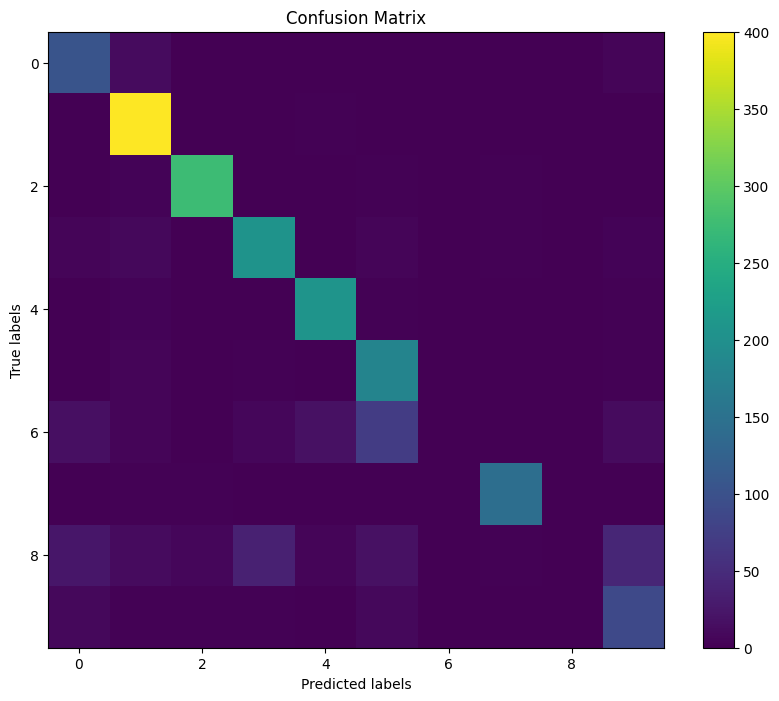

In [18]:
# Evaluating the model on the validation dataset
model.eval()
totalcorrect = 0
totaltargets = []
totalpredictions = []
with torch.no_grad():
    for data, target in DataLoader(valdataset, batch_size=128, shuffle=False):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        totalcorrect += (predicted == target).sum().item()
        totaltargets.extend(target.cpu().numpy())
        totalpredictions.extend(predicted.cpu().numpy())

accuracy = totalcorrect / len(valdataset)
print(f'Validation Accuracy: {accuracy:.2f}')

# Calculating Classification Report
print('Classification Report:')
print(classification_report(totaltargets, totalpredictions, zero_division = 0))

# Calculating Confusion Matrix
print('Confusion Matrix:')
print(confusion_matrix(totaltargets, totalpredictions))

# Visualizing the model's predictions and misclassifications
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix(totaltargets, totalpredictions), interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


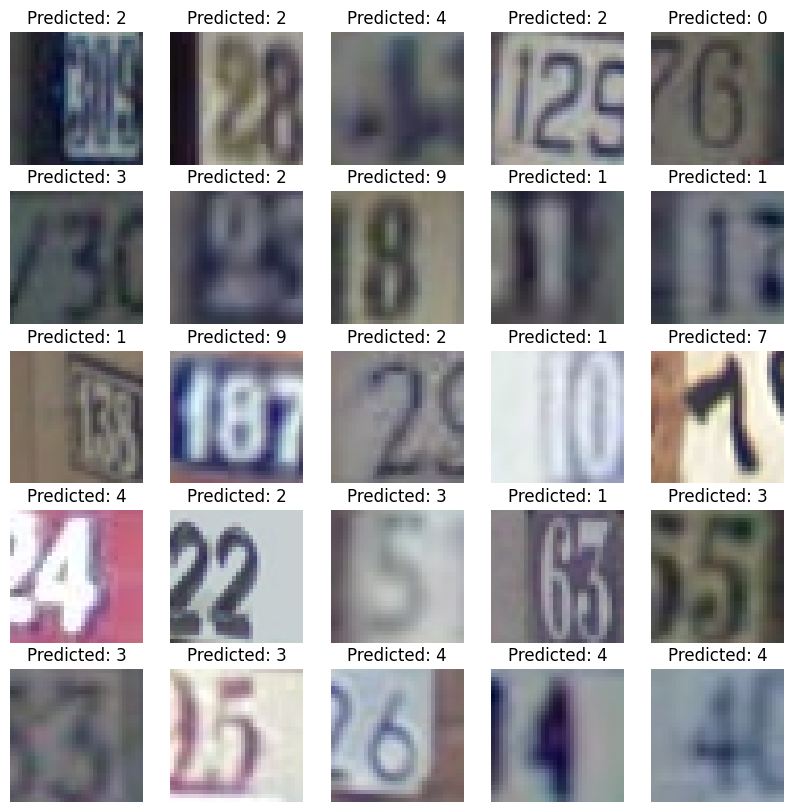

In [34]:
# Visualizing the predicted images
plt.figure(figsize=(10, 10))
for i in range(25):  # displaying 25 images
    img, label = valdataset[i]
    img = img.to(device)
    output = model(img.unsqueeze(0))
    _, predicted = torch.max(output, 1)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img.cpu().numpy().transpose(1, 2, 0))  # converting to HWC format
    plt.title(f'Predicted: {predicted.item()}')
    plt.axis('off')
plt.show()

**Step 7: Fine Tuning and Iteration**

In [30]:
# Fine-tuning and iteration
bestaccuracy = 0
bestmodel = None

while accuracy < 0.80:  # iterating until the validation accuracy reaches 0.80
    model = SVNHModel()  # updating the model architecture
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=besthyperparameters[0])  # updating the learning rate

    # Training the model
    for epoch in range(besthyperparameters[2]):
        model.train()
        total_loss = 0
        correct = 0
        for batch_idx, (data, target) in enumerate(DataLoader(trainsubset, batch_size=besthyperparameters[1], shuffle=True)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

        accuracy = correct / len(trainsubset)
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(trainsubset):4f}, Accuracy: {accuracy:.2f}')

    # Evaluating the model on the validation dataset
    model.eval()
    totalcorrect = 0
    totaltargets = []
    totalpredictions = []
    with torch.no_grad():
        for data, target in DataLoader(valdataset, batch_size=64, shuffle=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            totalcorrect += (predicted == target).sum().item()
            totaltargets.extend(target.cpu().numpy())
            totalpredictions.extend(predicted.cpu().numpy())

    accuracy = totalcorrect / len(valdataset)
    print(f'Validation Accuracy: {accuracy:.2f}')

    if accuracy > bestaccuracy:
        bestaccuracy = accuracy
        bestmodel = model

print(f'Best Validation Accuracy: {bestaccuracy:.2f}')
print('Best Model:')
print(bestmodel)

Epoch 1, Loss: 0.034925, Accuracy: 0.24
Epoch 2, Loss: 0.033164, Accuracy: 0.36
Epoch 3, Loss: 0.032431, Accuracy: 0.40
Epoch 4, Loss: 0.032178, Accuracy: 0.41
Epoch 5, Loss: 0.031947, Accuracy: 0.43
Epoch 6, Loss: 0.031187, Accuracy: 0.49
Epoch 7, Loss: 0.030859, Accuracy: 0.51
Epoch 8, Loss: 0.030323, Accuracy: 0.55
Epoch 9, Loss: 0.029394, Accuracy: 0.61
Epoch 10, Loss: 0.029067, Accuracy: 0.62
Epoch 11, Loss: 0.028958, Accuracy: 0.63
Epoch 12, Loss: 0.028817, Accuracy: 0.64
Epoch 13, Loss: 0.028694, Accuracy: 0.64
Epoch 14, Loss: 0.028158, Accuracy: 0.68
Epoch 15, Loss: 0.027923, Accuracy: 0.70
Epoch 16, Loss: 0.027770, Accuracy: 0.71
Epoch 17, Loss: 0.027660, Accuracy: 0.71
Epoch 18, Loss: 0.027560, Accuracy: 0.72
Epoch 19, Loss: 0.027493, Accuracy: 0.72
Epoch 20, Loss: 0.027441, Accuracy: 0.72
Validation Accuracy: 0.75
Epoch 1, Loss: 0.034702, Accuracy: 0.25
Epoch 2, Loss: 0.033266, Accuracy: 0.34
Epoch 3, Loss: 0.032137, Accuracy: 0.42
Epoch 4, Loss: 0.031174, Accuracy: 0.50
Epo

**Step : Final Model Testing**

Test Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.81      0.70       684
           1       0.87      0.94      0.90      1968
           2       0.83      0.88      0.85      1590
           3       0.72      0.81      0.76      1104
           4       0.80      0.85      0.83       964
           5       0.52      0.86      0.65       909
           6       0.00      0.00      0.00       773
           7       0.83      0.81      0.82       767
           8       0.54      0.70      0.61       621
           9       0.00      0.00      0.00       620

    accuracy                           0.73     10000
   macro avg       0.57      0.67      0.61     10000
weighted avg       0.65      0.73      0.69     10000

Confusion Matrix:
[[ 551   30   26   25   10   23    0    5   14    0]
 [  23 1845   17   12   35   19    0   14    3    0]
 [  11   26 1394   31   29   38    0   55    6    0]
 [   9   47   34  895

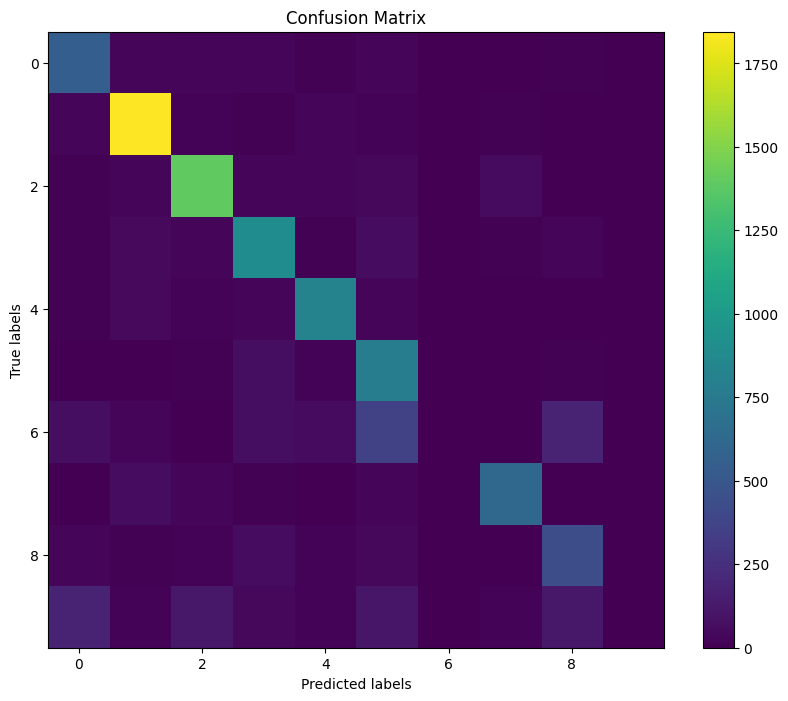

In [32]:
# Testing the model 
model.eval()
totalcorrect = 0
totaltargets = []
totalpredictions = []
with torch.no_grad():
    for data, target in DataLoader(testdataset, batch_size=128, shuffle=False):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        totalcorrect += (predicted == target).sum().item()
        totaltargets.extend(target.cpu().numpy())
        totalpredictions.extend(predicted.cpu().numpy())

accuracy = totalcorrect / len(testdataset)
print(f'Test Accuracy: {accuracy:.2f}')

# Calculating Classification Report
print('Classification Report:')
print(classification_report(totaltargets, totalpredictions, zero_division = 0))

# Calculating Confusion Matrix
print('Confusion Matrix:')
print(confusion_matrix(totaltargets, totalpredictions))

# Visualizing the model's predictions and misclassifications
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix(totaltargets, totalpredictions), interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

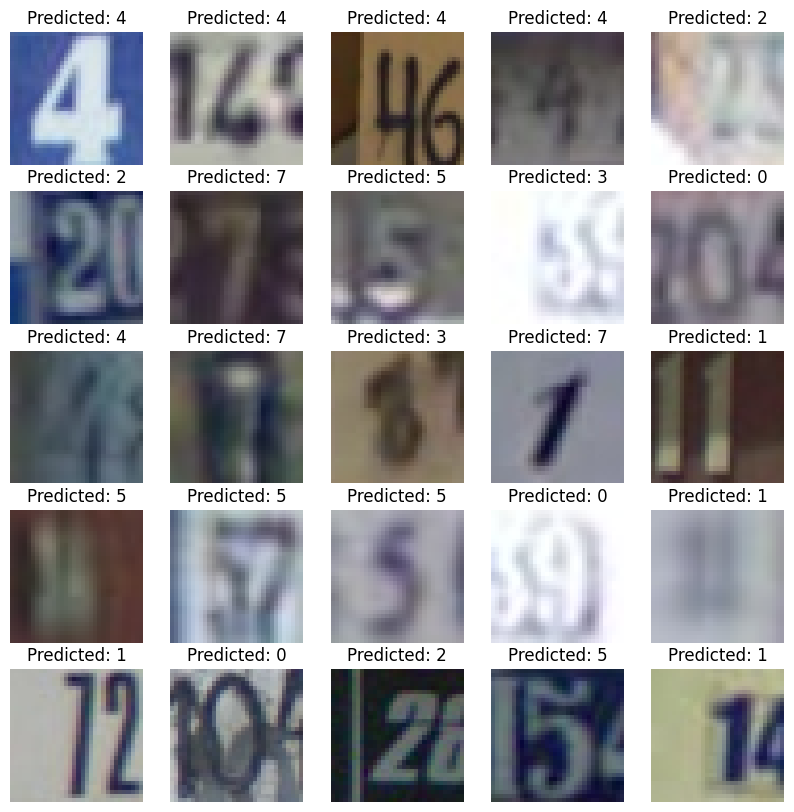

In [42]:
plt.figure(figsize=(10, 10))
for i in range(25):  # displaying 25 images
    img, label = valdataset[i]
    img = img.to(device)
    output = model(img.unsqueeze(0))
    _, predicted = torch.max(output, 1)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img.cpu().numpy().transpose(1, 2, 0))  # converting to HWC format
    plt.title(f'Predicted: {predicted.item()}')
    plt.axis('off')
plt.show()


**Refrences**

https://pytorch.org/tutorials/
https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
https://github.com/pytorch/pytorch/blob/main/torch/utils/data/dataset.py
https://pytorch.org/tutorials/intermediate/cifar_tutorial.html
https://pytorch.org/tutorials/intermediate/image_generation_tutorial.html

